#Housekeeping

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

from typing import Callable, List, Dict
import warnings
warnings.filterwarnings("ignore")
import math
from sklearn.decomposition import PCA

%load_ext google.colab.data_table

Mounted at /content/drive


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, cross_validate
from xgboost import XGBRegressor

from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
data_folder = Path(r'/content/drive/MyDrive/All hw colab/MSE723_HW3')

In [5]:
training_data: pd.DataFrame = pd.read_pickle(data_folder/'training_dataset.pkl')
training_data.shape

(413, 24)

# Data Analysis

In [6]:
training_data.columns

Index(['mn', 'dispersity', 'concentration', 'dielectric_thickness',
       'channel_length', 'channel_width', 'postprocess.annealing.temperature',
       'deposition_type encoded', 'electrode_configuration encoded',
       'params.environment encoded', 'ofet.environment encoded', 'solvent dP',
       'polymer dP', 'solvent dD', 'polymer dD', 'solvent dH', 'polymer dH',
       'Ra', 'abs(solvent dD - polymer dD)', 'abs(solvent dP - polymer dP)',
       'abs(solvent dH - polymer dH)', 'poly_smile_ECFP12_count_4096bits',
       'poly_smile_Mordred', 'ofet.hole_mobility'],
      dtype='object')

**Challenges in Feature Selection**

a. Dimensionality Reduction

poly_smile_ECFP12_count_4096bits and poly_smile_Mordred, are often treated as holistic representations of a molecular structure rather than individual features.

Loss of Interpretability: Selecting specific bits from a fingerprint can be challenging to interpret because each bit corresponds to a complex, often opaque molecular substructure.

automated feature selection was done on Mordred where discriptors with nan value or zero varience were droped.

b. Correlation Analysis

Features like mn and dispersity may be correlated since they describe molecular properties. Similarly, abs(solvent dD - polymer dD) could be related to solvent dD and polymer dD.
Correlation analysis (using Pearson/Spearman coefficients) can help identify and remove highly correlated or redundant features.

Mw was dropped as it was highly correlated with Mn value.

c. Categorical Features

Encoded categorical features like deposition_type encoded should be evaluated for relevance, as some might have weak correlations with the target variable.
One-hot encoding can introduce sparsity; careful preprocessing is necessary to ensure interpretability.

d. Interaction Effects

Combinations of features (e.g., channel_length and channel_width) might interact significantly. Polynomial features or interaction terms might be worth exploring for models that can handle them.
e. Target-Specific Feature Importance
If the dataset has multiple target variables (e.g., mobility, threshold voltage), the importance of features may vary for each. Perform separate feature importance analysis for each target.

f. Domain Knowledge

Domain knowledge is crucial, especially for interpreting polymer properties (e.g., poly_smile_ECFP12_count_4096bits) and Hansen solubility parameters (dP, dD, dH). Features like abs(solvent dD - polymer dD) are likely highly informative for solubility and miscibility studies.

g. Overfitting Risk

Including high-dimensional and irrelevant features can lead to overfitting. Regularization techniques (e.g., Lasso, Ridge) can enforce sparsity in the selected features.

In [12]:
def draw_correlation_heatmap(df: pd.DataFrame, parameters: list,title:str=''):
    """
    Draws a heatmap for the Spearman correlation of the specified parameters from the DataFrame.

    Parameters:
    - df: pd.DataFrame - The DataFrame containing the data to analyze.
    - parameters: list - A list of column names to include in the correlation plot.
    """
    # Compute the Spearman correlation matrix
    corrmatrix = df[parameters].corr(method='spearman')
    # Set up the matplotlib figure
    plt.figure(figsize=(14, 14))

    # Draw the heatmap
    ax=sns.heatmap(
            corrmatrix,
            vmin=-1,
            vmax=1,
            linewidths=.5,
            square=True,
            center=0,
            cmap='BrBG',
            cbar_kws={"shrink": .3},
            annot=True,
            fmt=".2f",

            # Format for the correlation coefficient
            )

    # Set title
    plt.title(title, fontsize=16,fontweight='bold')
    for label in ax.get_xticklabels():
        label.set_fontsize(12)
        label.set_fontweight('bold')

    for label in ax.get_yticklabels():
        label.set_fontsize(12)
        label.set_fontweight('bold')

    plt.xticks(rotation=45, ha='right')

    plt.show()  # Show the plot

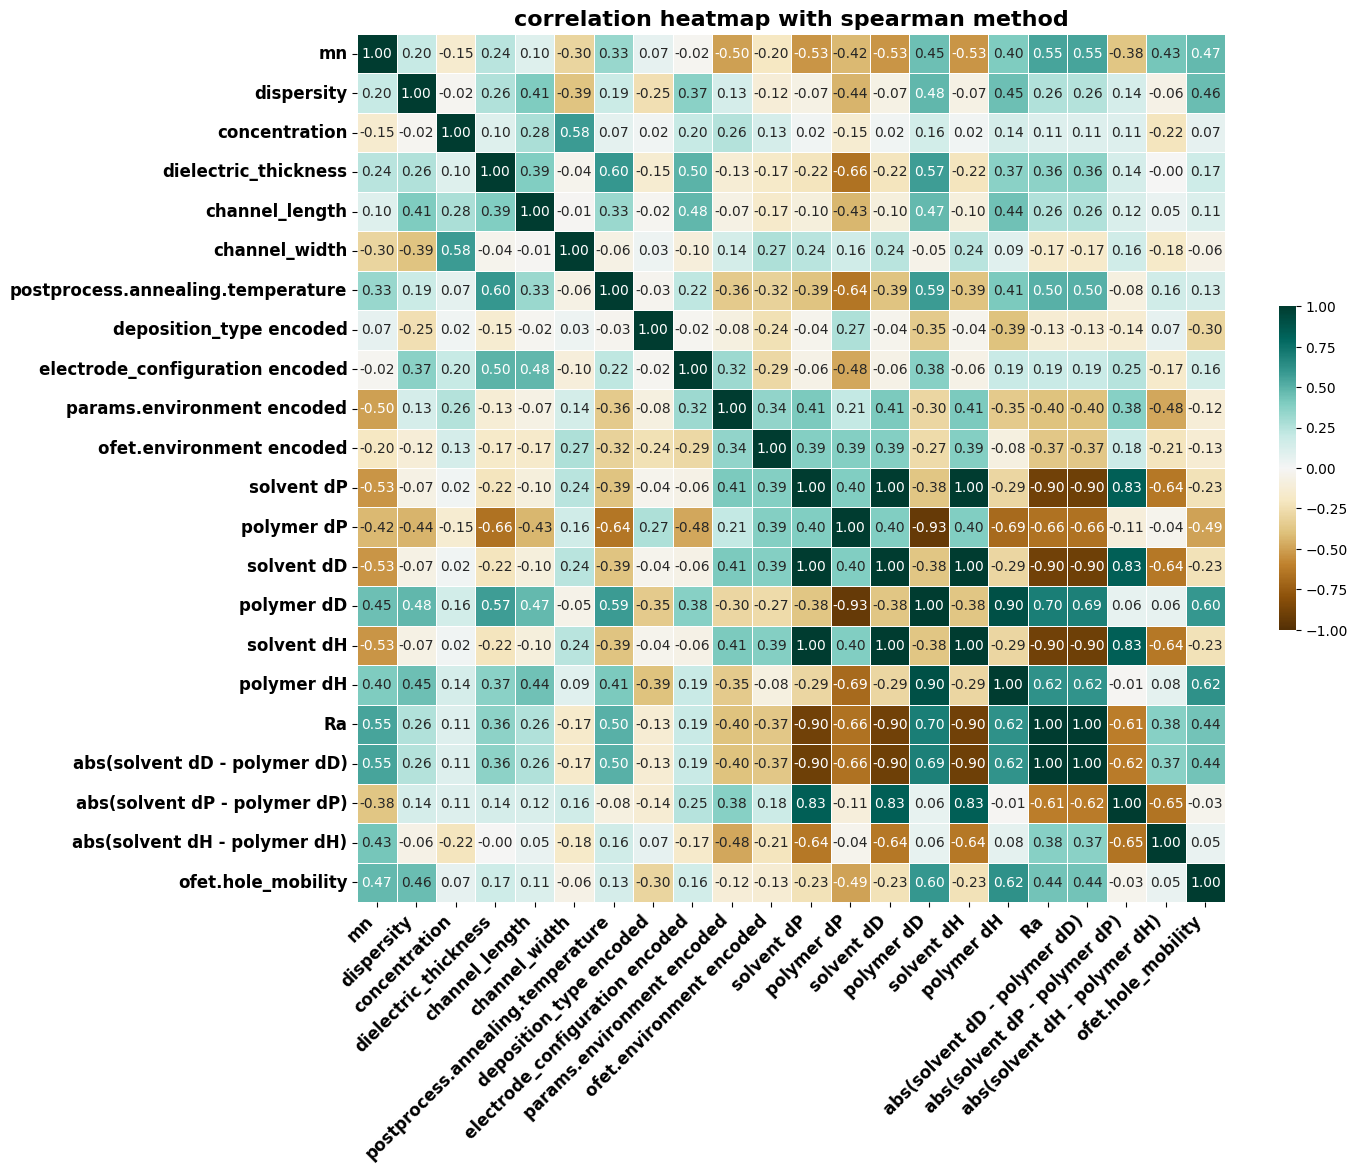

In [13]:
feats_to_show = ['mn', 'dispersity','concentration','dielectric_thickness','channel_length', 'channel_width',
'postprocess.annealing.temperature', 'deposition_type encoded', 'electrode_configuration encoded',
       'params.environment encoded', 'ofet.environment encoded', 'solvent dP',
       'polymer dP', 'solvent dD', 'polymer dD', 'solvent dH', 'polymer dH',
       'Ra', 'abs(solvent dD - polymer dD)', 'abs(solvent dP - polymer dP)',
       'abs(solvent dH - polymer dH)','ofet.hole_mobility']

draw_correlation_heatmap(df=training_data, parameters=feats_to_show,title=f"correlation heatmap with spearman method")

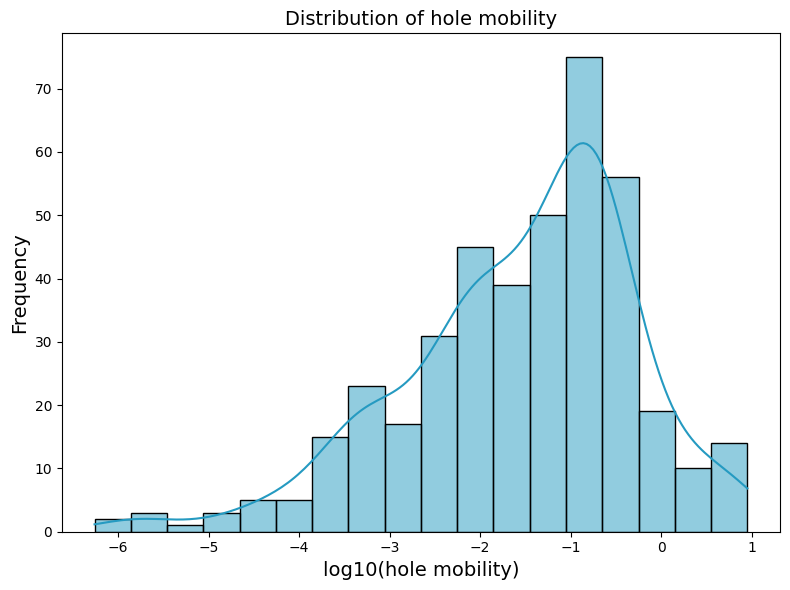

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))
sns.histplot(np.log10(training_data['ofet.hole_mobility']), ax=axes, kde=True, color='#259AC1')

# Customize plot
axes.set_title("Distribution of hole mobility", fontsize=14)
axes.set_xlabel("log10(hole mobility)", fontsize=14)
axes.set_ylabel("Frequency", fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

According to above plot, the distribution of log (hole mobility) is more or less normal. So, I'll use log transformer for training the the target.

## training models

In [15]:
numerical_training_data = training_data[feats_to_show].copy()

In [16]:
X = numerical_training_data.drop(columns=['ofet.hole_mobility'])  # Features
y = numerical_training_data['ofet.hole_mobility']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Filter-based Feature Selection using SelectKBest
k_best_selector = SelectKBest(score_func=f_regression, k=6)
X_train_kbest = k_best_selector.fit_transform(X_train, y_train)
X_test_kbest = k_best_selector.transform(X_test)

# Get selected feature names
selected_features = X.columns[k_best_selector.get_support()]
print(f"Top 10 Features Selected by SelectKBest: {list(selected_features)}")

Top 10 Features Selected by SelectKBest: ['postprocess.annealing.temperature', 'ofet.environment encoded', 'polymer dP', 'polymer dD', 'Ra', 'abs(solvent dD - polymer dD)']


In [ ]:
# Train RF Model on Top 5 Features

rf_kbest = RandomForestRegressor(random_state=42)
rf_kbest.fit(X_train_kbest, y_train)
y_pred_kbest = rf_kbest.predict(X_test_kbest)

# Evaluate RF Model with Top 5 Features
mse_kbest = mean_squared_error(y_test, y_pred_kbest)
r2_kbest = r2_score(y_test, y_pred_kbest)

# Train RF Model on All Features
rf_all = RandomForestRegressor(random_state=42)
rf_all.fit(X_train, y_train)
y_pred_all = rf_all.predict(X_test)

# Evaluate RF Model with All Features
mse_all = mean_squared_error(y_test, y_pred_all)
r2_all = r2_score(y_test, y_pred_all)

# 2. Recursive Feature Elimination (RFE) for Top 3 Features
rfe_selector = RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=6)
rfe_selector.fit(X_train, y_train)

X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)

# Train RF Model on Top 5 Features
rf_rfe = RandomForestRegressor(random_state=42)
rf_rfe.fit(X_train_rfe, y_train)
y_pred_rfe = rf_rfe.predict(X_test_rfe)

# Evaluate RF Model with Top 5 Features
mse_rfe = mean_squared_error(y_test, y_pred_rfe)
r2_rfe = r2_score(y_test, y_pred_rfe)

In [ ]:
# 3. Report and Compare Results
print("\nModel Performance Comparison:")
print(f"Model with All Features: MSE = {mse_all:.4f}, R² = {r2_all:.4f}")
print(f"Model with Top 6 Features (SelectKBest): MSE = {mse_kbest:.4f}, R² = {r2_kbest:.4f}")
print(f"Model with Top 6 Features (RFE): MSE = {mse_rfe:.4f}, R² = {r2_rfe:.4f}")


Model Performance Comparison:
Model with All Features: MSE = 0.9628, R² = 0.7124
Model with Top 6 Features (SelectKBest): MSE = 1.0691, R² = 0.6807
Model with Top 6 Features (RFE): MSE = 1.0168, R² = 0.6963


In [ ]:
def get_target_transformer(transformer,target_name) -> Pipeline:

        # Apply log transformation followed by StandardScaler for Rh
        return Pipeline(steps=[
            ("log transform", FunctionTransformer(np.log10, inverse_func=lambda x: 10**x,
                                                  check_inverse=True, validate=False)),  # log10(x)
            ("y scaler", transforms[transformer])  # StandardScaler to standardize the log-transformed target
            ])

regressor :Pipeline= Pipeline(steps=[
                    ("preprocessor", preprocessor),
                    ("regressor", y_transform_regressor),
                        ])

In [ ]:
# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('rf', RandomForestRegressor(random_state=42))
])

# Random Forest Hyperparameter Grid
param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10,20,30]
}

# GridSearchCV for Random Forest
grid_rf = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best hyperparameters for Random Forest
print(f"Best Random Forest Hyperparameters: {grid_rf.best_params_}")
rf_best = grid_rf.best_estimator_

# Evaluate Random Forest
y_pred_rf = rf_best.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")

Best Random Forest Hyperparameters: {'rf__max_depth': 10, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Random Forest MSE: 0.9066, R²: 0.7292


In [ ]:
# Evaluate on training set for overfitting/underfitting comparison
y_pred_rf_train = rf_best.predict(X_train)
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
r2_rf_train = r2_score(y_train, y_pred_rf_train)

print("\nModel Performance on Training and Test Sets:")
print(f"Random Forest: Training MSE = {mse_rf_train:.4f}, R² = {r2_rf_train:.4f}")
print(f"Random Forest: Test MSE = {mse_rf:.4f}, R² = {r2_rf:.4f}")


Model Performance on Training and Test Sets:
Random Forest: Training MSE = 0.2186, R² = 0.7852
Random Forest: Test MSE = 0.9066, R² = 0.7292


In [ ]:
def cross_validate_regressor(
    regressor, X, y, cv
    ) -> tuple[dict[str, float], np.ndarray]:

    predictions: np.ndarray = cross_val_predict(
        regressor,
        X,
        y,
        cv=cv,
        n_jobs=-1,
    )
    return predictions


cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
y_pred_rf_overall = cross_validate_regressor(rf_best,X,y,cv_outer)


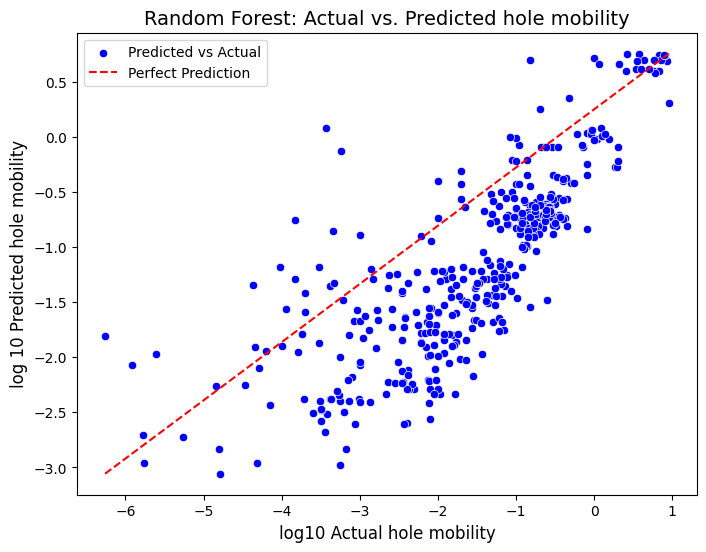

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.log10(y), y=np.log10(y_pred_rf_overall), color='blue', label='Predicted vs Actual')
plt.plot([np.log10(y).min(), np.log10(y).max()], [np.log10(y_pred_rf_overall).min(), np.log10(y_pred_rf_overall).max()], color='red', linestyle='--', label='Perfect Prediction')

# Set plot labels and title
plt.title('Random Forest: Actual vs. Predicted hole mobility', fontsize=14)
plt.xlabel('log10 Actual hole mobility', fontsize=12)
plt.ylabel('log 10 Predicted hole mobility', fontsize=12)

# Show the legend
plt.legend()

# Show the plot
plt.show()

**Discussion**

The points align somewhat along the diagonal line, suggesting the model captures the overall relationship between the actual and predicted hole mobility values.

Many points cluster around the middle range of actual hole mobility values (e.g., log10 actual values between -2 and -1), which suggests the model has better performance in this range.

Predictions appear to slightly underestimate higher values (log10 actual values near or above 0) and overestimate lower values (log10 actual values below -4), which could indicate a bias in the model.

I can Add feature importance after training RF to see which parameters has the most effect in predicting the target.

In [ ]:
xgbr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('xgbr', XGBRegressor(random_state=42))
])

# XGBoost Hyperparameter Grid
param_grid_xgbr = {
    'xgbr__n_estimators': [50, 100, 200],
    'xgbr__max_depth': [5, 10, 15],
    'xgbr__learning_rate': [0.01, 0.05, 0.1],
    'xgbr__subsample': [0.8, 1.0],
    'xgbr__colsample_bytree': [0.8, 1.0]
}

# GridSearchCV for XGBoost Regressor
grid_xgbr = GridSearchCV(estimator=xgbr_pipeline, param_grid=param_grid_xgbr, cv=5, n_jobs=-1)
grid_xgbr.fit(X_train, y_train)

# Best hyperparameters for XGBoost Regressor
print(f"Best XGBoost Regressor Hyperparameters: {grid_xgbr.best_params_}")
xgbr_best = grid_xgbr.best_estimator_

# Evaluate XGBoost Regressor on Training Set
y_pred_train_xgbr = xgbr_best.predict(X_train)
mse_train_xgbr = mean_squared_error(y_train, y_pred_train_xgbr)
r2_train_xgbr = r2_score(y_train, y_pred_train_xgbr)
print(f"XGBoost Regressor (Training) MSE: {mse_train_xgbr:.4f}, R²: {r2_train_xgbr:.4f}")

# Evaluate XGBoost Regressor on Test Set
y_pred_xgbr = xgbr_best.predict(X_test)
mse_xgbr = mean_squared_error(y_test, y_pred_xgbr)
r2_xgbr = r2_score(y_test, y_pred_xgbr)
print(f"XGBoost Regressor (Test) MSE: {mse_xgbr:.4f}, R²: {r2_xgbr:.4f}")

# Plot Actual vs Predicted Yield Strength (XGBoost)
y_pred_xgbr_overall = cross_validate_regressor(xgbr_best,X,y,cv_outer)


Best XGBoost Regressor Hyperparameters: {'xgbr__colsample_bytree': 0.8, 'xgbr__learning_rate': 0.01, 'xgbr__max_depth': 5, 'xgbr__n_estimators': 200, 'xgbr__subsample': 0.8}
XGBoost Regressor (Training) MSE: 0.1570, R²: 0.8458
XGBoost Regressor (Test) MSE: 1.2435, R²: 0.6286


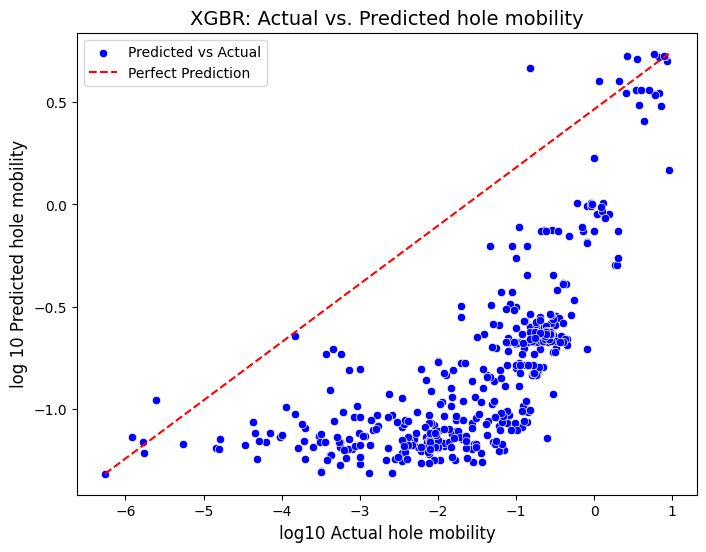

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=np.log10(y), y=np.log10(y_pred_xgbr_overall), color='blue', label='Predicted vs Actual')

# Plot a line of perfect prediction (y = x)
plt.plot([np.log10(y).min(), np.log10(y).max()], [np.log10(y_pred_xgbr_overall).min(), np.log10(y_pred_xgbr_overall).max()], color='red', linestyle='--', label='Perfect Prediction')

# Set plot labels and title
plt.title('XGBR: Actual vs. Predicted hole mobility', fontsize=14)
plt.xlabel('log10 Actual hole mobility', fontsize=12)
plt.ylabel('log 10 Predicted hole mobility', fontsize=12)

# Show the legend
plt.legend()

# Show the plot
plt.show()

Compared to the previous model, this plot shows better alignment of the points along the diagonal, especially for moderate and high actual values (e.g., log10 actual values near -2 to 1). This suggests the XGBR model has improved predictive accuracy in these regions.
Spread of Predictions:

Predictions for very low actual values (log10 values below -4) show a larger spread, indicating some difficulty in accurately predicting these extreme cases.